# Regensburg Pediatric Appendicitis

In [16]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# fetch dataset 
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)   
# data (as pandas dataframes) 
X = regensburg_pediatric_appendicitis.data.features 
y = regensburg_pediatric_appendicitis.data.targets 
df = pd.concat([X, y], axis=1)
df.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,Neutrophil_Percentage,Segmented_Neutrophils,Neutrophilia,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,Ketones_in_Urine,RBC_in_Urine,WBC_in_Urine,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,US_Number,Free_Fluids,Appendix_Wall_Layers,Target_Sign,Appendicolith,Perfusion,Perforation,Surrounding_Tissue_Reaction,Appendicular_Abscess,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Management,Severity,Diagnosis
0,12.68,16.9,female,148.0,37.0,3.0,4.0,3.0,yes,7.1,no,yes,yes,no,no,yes,37.0,7.7,68.2,NaN,no,5.27,14.8,12.2,254.0,++,+,no,0.0,no,normal,no,yes,no,yes,882.0,no,intact,NaN,suspected,NaN,no,yes,no,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conservative,uncomplicated,appendicitis
1,14.10,31.9,male,147.0,69.5,2.0,5.0,4.0,no,NaN,yes,yes,yes,no,no,yes,36.9,8.1,64.8,NaN,no,5.26,15.7,12.7,151.0,no,no,no,3.0,yes,normal,no,yes,no,yes,883.0,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,conservative,uncomplicated,no appendicitis
2,14.14,23.3,female,163.0,62.0,4.0,5.0,3.0,no,NaN,no,yes,yes,no,no,no,36.6,13.2,74.8,NaN,no,3.98,11.4,12.2,300.0,no,no,no,3.0,no,constipation,no,yes,no,yes,884.0,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,NaN,conservative,uncomplicated,no appendicitis
3,16.37,20.6,female,165.0,56.0,3.0,7.0,6.0,no,NaN,yes,yes,no,no,yes,yes,36.0,11.4,63.0,NaN,no,4.64,13.6,13.2,258.0,no,no,no,0.0,yes,normal,no,yes,no,yes,886.0,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,no appendicitis
4,11.08,16.9,female,163.0,45.0,3.0,5.0,6.0,yes,7.0,no,yes,yes,yes,yes,yes,36.9,8.1,44.0,NaN,no,4.44,12.6,13.6,311.0,no,no,no,0.0,no,constipation,no,yes,no,yes,887.0,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,appendicitis


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 57 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

# Data Cleaning + Preparation

We observe from the info that some columns have majority of values null and it would be best to drop them

In [18]:
df_cols = df.columns
row, column = df.shape
keep_cols = []
for col in df_cols:
    if ((df[col].isna().sum()/column)*100) > 50:
        continue
    keep_cols.append(col)
df_new = df.loc[:, keep_cols]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Appendix_on_US                    777 non-null    object 
 7   Migratory_Pain                    773 non-null    object 
 8   Lower_Right_Abd_Pain              774 non-null    object 
 9   Contralateral_Rebound_Tenderness  767 non-null    object 
 10  Coughing_Pain                     766 non-null    object 
 11  Nausea                            774 non-null    object 
 12  Loss_of_

The data looks much better now after dropping columns that are not needed. We will prepare the data before training the model.

In [19]:
df_new.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP,Stool,Peritonitis,US_Performed,US_Number,Management,Severity,Diagnosis
0,12.68,16.9,female,148.0,37.0,3.0,yes,no,yes,yes,no,no,yes,37.0,7.7,5.27,14.8,12.2,254.0,0.0,normal,no,yes,882.0,conservative,uncomplicated,appendicitis
1,14.10,31.9,male,147.0,69.5,2.0,no,yes,yes,yes,no,no,yes,36.9,8.1,5.26,15.7,12.7,151.0,3.0,normal,no,yes,883.0,conservative,uncomplicated,no appendicitis
2,14.14,23.3,female,163.0,62.0,4.0,no,no,yes,yes,no,no,no,36.6,13.2,3.98,11.4,12.2,300.0,3.0,constipation,no,yes,884.0,conservative,uncomplicated,no appendicitis
3,16.37,20.6,female,165.0,56.0,3.0,no,yes,yes,no,no,yes,yes,36.0,11.4,4.64,13.6,13.2,258.0,0.0,normal,no,yes,886.0,conservative,uncomplicated,no appendicitis
4,11.08,16.9,female,163.0,45.0,3.0,yes,no,yes,yes,yes,yes,yes,36.9,8.1,4.44,12.6,13.6,311.0,0.0,constipation,no,yes,887.0,conservative,uncomplicated,appendicitis


For the remaining columns with few missing values, we will eaither fill them with mean or mode based on the data type (numerical or categorical). 

In [20]:
num_cols = df_new.select_dtypes(include='number').columns
cat_cols = df_new.select_dtypes(exclude='number').columns
df_new = df_new.loc[~(df_new.Management.isna() | df_new.Severity.isna() | df_new.Diagnosis.isna())]
df_new.dropna(thresh=5, inplace=True)

for col in num_cols:
    df_new.loc[df_new[col].isna(), col] = df_new[col].mean()
    if col in ['Length_of_Stay', 'Thrombocyte_Count', 'CRP', 'US_Number', 'Age']:
        df_new[col] = df_new[col].astype(int)

for col in cat_cols:
    df_new[col] = df_new[col].astype('category')
    df_new.loc[df_new[col].isna(), col] = df_new[col].mode()[0]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 781
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Age                               780 non-null    int32   
 1   BMI                               780 non-null    float64 
 2   Sex                               780 non-null    category
 3   Height                            780 non-null    float64 
 4   Weight                            780 non-null    float64 
 5   Length_of_Stay                    780 non-null    int32   
 6   Appendix_on_US                    780 non-null    category
 7   Migratory_Pain                    780 non-null    category
 8   Lower_Right_Abd_Pain              780 non-null    category
 9   Contralateral_Rebound_Tenderness  780 non-null    category
 10  Coughing_Pain                     780 non-null    category
 11  Nausea                            780 non-null    category
 12 

In [21]:
df_new.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP,Stool,Peritonitis,US_Performed,US_Number,Management,Severity,Diagnosis
0,12,16.9,female,148.0,37.0,3,yes,no,yes,yes,no,no,yes,37.0,7.7,5.27,14.8,12.2,254,0,normal,no,yes,882,conservative,uncomplicated,appendicitis
1,14,31.9,male,147.0,69.5,2,no,yes,yes,yes,no,no,yes,36.9,8.1,5.26,15.7,12.7,151,3,normal,no,yes,883,conservative,uncomplicated,no appendicitis
2,14,23.3,female,163.0,62.0,4,no,no,yes,yes,no,no,no,36.6,13.2,3.98,11.4,12.2,300,3,constipation,no,yes,884,conservative,uncomplicated,no appendicitis
3,16,20.6,female,165.0,56.0,3,no,yes,yes,no,no,yes,yes,36.0,11.4,4.64,13.6,13.2,258,0,normal,no,yes,886,conservative,uncomplicated,no appendicitis
4,11,16.9,female,163.0,45.0,3,yes,no,yes,yes,yes,yes,yes,36.9,8.1,4.44,12.6,13.6,311,0,constipation,no,yes,887,conservative,uncomplicated,appendicitis


# EDA

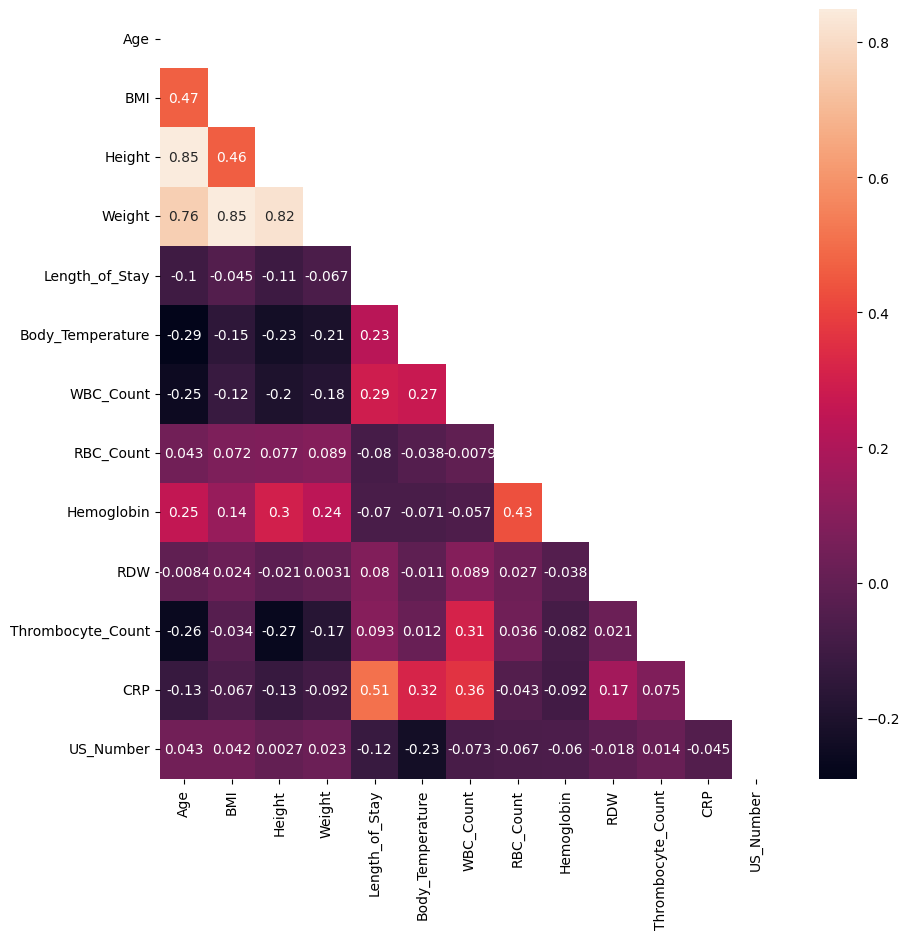

In [22]:
plt.figure(figsize=(10,10))
num_matrix = df_new.select_dtypes(include='number').corr()
sns.heatmap(num_matrix, annot=True, mask=np.triu(num_matrix))
plt.show()

We observe that the column Weight is highly correlated with various columns so it would be best to drop those columns as weight is an import feature when considering pediatrics.

In [23]:
scores = []
key_pair = set()
df_temp = df_new.dropna()
for col_x in cat_cols[:-3]:
    for col_y in y.columns:
        if col_x != col_y:
            if (col_y, col_x) not in key_pair:
                mis = mutual_info_score(df_temp[col_x], df_temp[col_y])
                # print(f'MIS of {col_x=} and {col_y=} is {round(mis,4)}')
                scores.append(((col_x, col_y), round(mis,4)))
scores.sort(key=lambda x: x[1], reverse=True)
for x, mis in scores:
    col_x, col_y = x
    print(f'MIS of {col_x=} and {col_y=} is {mis=}')


MIS of col_x='Peritonitis' and col_y='Management' is mis=0.1764
MIS of col_x='Appendix_on_US' and col_y='Diagnosis' is mis=0.0972
MIS of col_x='Peritonitis' and col_y='Diagnosis' is mis=0.0756
MIS of col_x='Peritonitis' and col_y='Severity' is mis=0.0522
MIS of col_x='Nausea' and col_y='Severity' is mis=0.0281
MIS of col_x='Loss_of_Appetite' and col_y='Severity' is mis=0.024
MIS of col_x='Nausea' and col_y='Management' is mis=0.0223
MIS of col_x='Loss_of_Appetite' and col_y='Management' is mis=0.0203
MIS of col_x='Contralateral_Rebound_Tenderness' and col_y='Management' is mis=0.0175
MIS of col_x='Nausea' and col_y='Diagnosis' is mis=0.0158
MIS of col_x='Contralateral_Rebound_Tenderness' and col_y='Diagnosis' is mis=0.0152
MIS of col_x='Loss_of_Appetite' and col_y='Diagnosis' is mis=0.0136
MIS of col_x='Appendix_on_US' and col_y='Management' is mis=0.0088
MIS of col_x='Sex' and col_y='Diagnosis' is mis=0.0073
MIS of col_x='US_Performed' and col_y='Management' is mis=0.0067
MIS of col_x

Considering the original problem had Management, Severity and Diagnosis as their target variables, we see we can get more information about Diagnosis and Severity from feature variables most of the time.  

We see columns such as Appendix_on_US, Loss_of_Appetite, and Nausea have considerable MIS which can be used to predict Diagnosis.

In [24]:
df_new.describe()

,Age,BMI,Height,Weight,Length_of_Stay,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP,US_Number
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,10.846154,18.905138,147.997616,43.158625,4.284615,37.404516,12.670683,4.799490,13.380497,13.180291,285.247436,31.382051,425.333333
std,3.510399,4.314092,19.418250,17.375482,2.570399,0.900773,5.352729,0.493861,1.378889,4.468310,71.746033,57.101335,268.034766
min,0.000000,7.830000,53.000000,3.960000,1.000000,26.900000,2.600000,3.620000,8.200000,11.200000,91.000000,0.000000,1.000000
25%,9.000000,15.797500,137.875000,29.500000,3.000000,36.800000,8.275000,4.540000,12.700000,12.300000,236.000000,1.000000,203.750000
50%,11.000000,18.245000,149.000000,41.400000,3.000000,37.200000,12.000000,4.790000,13.380497,12.800000,277.000000,7.000000,408.500000
75%,14.000000,21.022500,162.075000,54.000000,5.000000,37.900000,16.200000,5.010000,14.000000,13.300000,329.250000,32.000000,604.500000
max,18.000000,38.160000,192.000000,103.000000,28.000000,40.200000,37.700000,14.000000,36.000000,86.900000,708.000000,365.000000,992.000000


In [25]:
df_new.loc[df_new.Age == 0]

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP,Stool,Peritonitis,US_Performed,US_Number,Management,Severity,Diagnosis
405,0,18.49,male,143.0,37.80,3,yes,yes,yes,no,no,no,yes,38.8,11.1,4.91,14.0,13.000000,273,11,normal,no,yes,376,conservative,uncomplicated,no appendicitis
638,0,20.37,male,176.0,63.10,3,yes,no,yes,yes,no,no,no,37.5,14.5,5.18,14.5,11.800000,232,1,normal,no,yes,198,primary surgical,uncomplicated,appendicitis
656,0,17.10,male,164.0,46.00,6,yes,no,yes,no,no,no,no,37.4,14.4,5.10,14.2,12.900000,242,4,normal,local,yes,205,primary surgical,uncomplicated,appendicitis
676,0,14.10,male,53.0,3.96,12,yes,no,yes,no,no,no,yes,38.7,8.7,4.59,15.3,13.180291,440,198,diarrhea,local,yes,260,primary surgical,complicated,appendicitis


The above samples indicate information about patients that are babies. Babies with height and weight below average of their age group show complicated case of appendicitis.

In [26]:
df_new.describe(exclude='number')

,Sex,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Stool,Peritonitis,US_Performed,Management,Severity,Diagnosis
count,780,780,780,780,780,780,780,780,780,780,780,780,780,780
unique,2,2,2,2,2,2,2,2,4,3,2,4,2,2
top,male,yes,no,yes,no,no,yes,yes,normal,no,yes,conservative,uncomplicated,appendicitis
freq,404,507,569,739,482,562,459,400,564,547,766,483,661,463


In [27]:
df_new.Stool.value_counts()

Stool
normal                    564
diarrhea                  128
constipation               87
constipation, diarrhea      1
Name: count, dtype: int64

In [28]:
df_new.loc[df_new.Stool == 'constipation, diarrhea']

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP,Stool,Peritonitis,US_Performed,US_Number,Management,Severity,Diagnosis
523,2,14.77,male,92.0,12.5,13,no,no,no,no,no,yes,yes,39.6,21.9,4.28,10.7,12.1,455,162,"constipation, diarrhea",generalized,yes,542,primary surgical,complicated,appendicitis


We will remove this row to avoid confusion. It should be learnt that this patient had a compicated case of appenditis.

In [29]:
df_new = df_new.loc[df_new.Stool != 'constipation, diarrhea', :]

In [30]:
df_new.Management.value_counts()

Management
conservative                 483
primary surgical             269
secondary surgical            26
simultaneous appendectomy      1
Name: count, dtype: int64

In [31]:
df_new.loc[df_new.Management == 'simultaneous appendectomy', :]

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP,Stool,Peritonitis,US_Performed,US_Number,Management,Severity,Diagnosis
773,15,18.83,female,158.0,47.0,4,no,no,yes,no,yes,yes,yes,37.2,8.6,4.54,14.0,12.2,176,0,normal,local,yes,425,simultaneous appendectomy,uncomplicated,no appendicitis


It would be best to remove the row as this is an outlier.

In [32]:
df_new = df_new.loc[df.Management != 'simultaneous appendectomy', :]

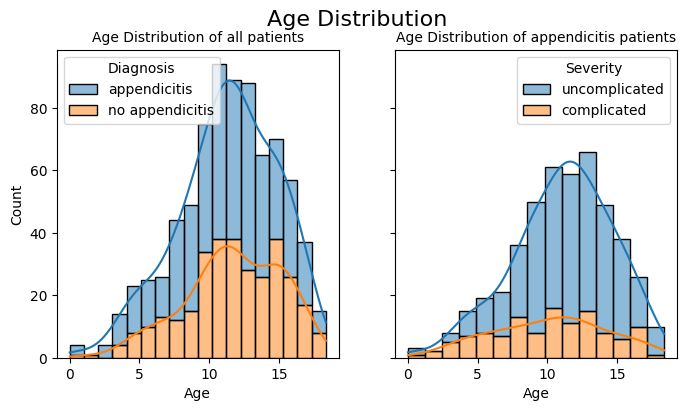

In [33]:
fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, sharey=True)
sns.histplot(data=df, x='Age', hue='Diagnosis', kde=True, ax=axes[0], multiple='stack')
sns.histplot(data=df.loc[df.Diagnosis=='appendicitis', :], x='Age', hue='Severity', kde=True, ax=axes[1], multiple='stack')
axes[0].set_title('Age Distribution of all patients', fontsize=10)
axes[1].set_title('Age Distribution of appendicitis patients', fontsize=10)
fig.suptitle('Age Distribution', fontsize=16)
plt.show()

We observe that 10-12 year olds constitute the largest age group of people in the dataset and while most of them are diagnosed with appendicitis, majority of cases are not complicated.

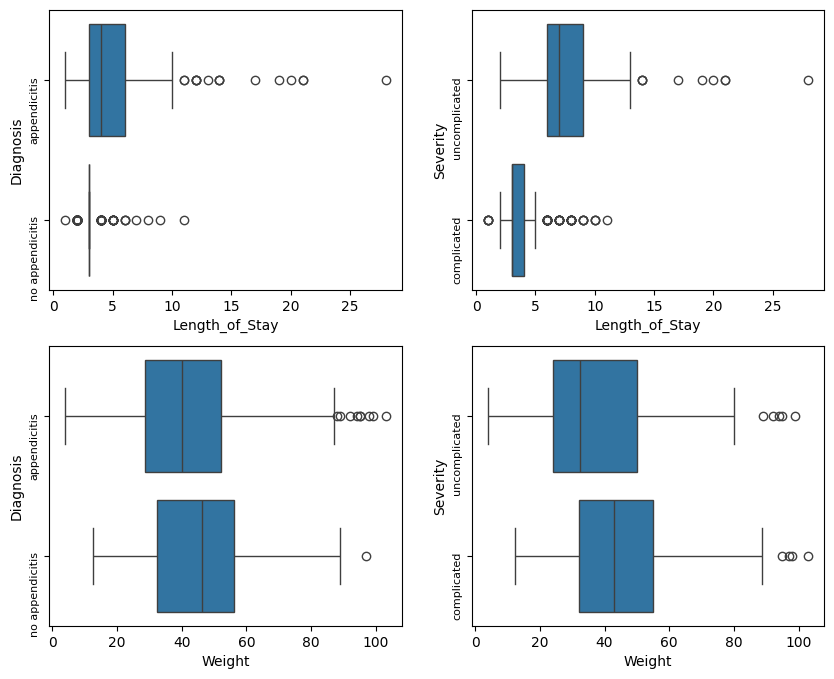

In [34]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
diagnosis = ['appendicitis', 'no appendicitis']
severity = ['uncomplicated', 'complicated']

sns.boxplot(x='Length_of_Stay', y='Diagnosis', data=df_new, ax=axes[0][0])
axes[0][0].set_yticklabels(diagnosis, rotation=90, fontsize=8)
sns.boxplot(x='Length_of_Stay', y='Severity', data=df_new, ax=axes[0][1])
axes[0][1].set_yticklabels(severity, rotation=90, fontsize=8)
sns.boxplot(x='Weight', y='Diagnosis', data=df_new, ax=axes[1][0])
axes[1][0].set_yticklabels(diagnosis, rotation=90, fontsize=8)
sns.boxplot(x='Weight', y='Severity', data=df_new, ax=axes[1][1])
axes[1][1].set_yticklabels(severity, rotation=90, fontsize=8)

plt.show()

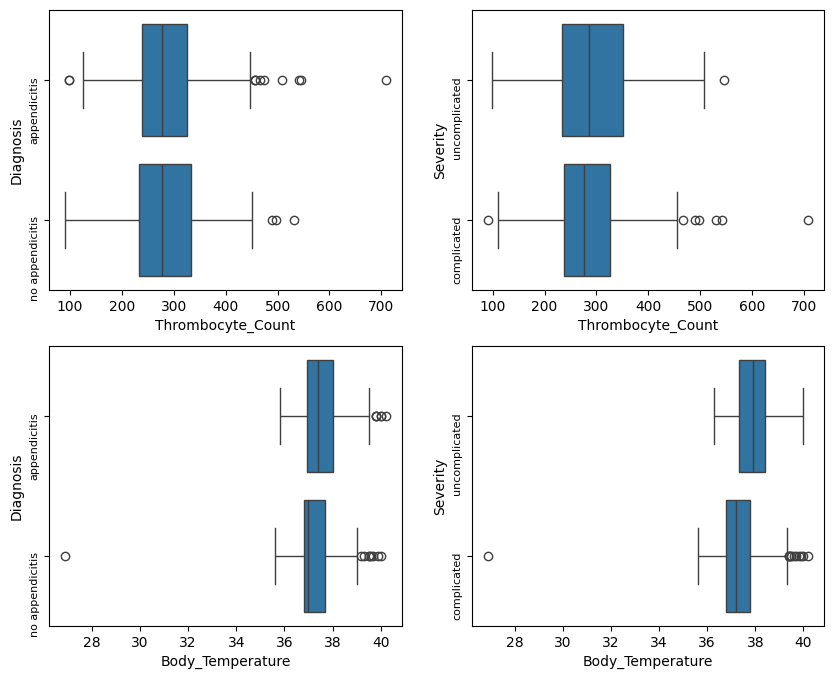

In [35]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
diagnosis = ['appendicitis', 'no appendicitis']
severity = ['uncomplicated', 'complicated']

sns.boxplot(x='Thrombocyte_Count', y='Diagnosis', data=df_new, ax=axes[0][0])
axes[0][0].set_yticklabels(diagnosis, rotation=90, fontsize=8)
sns.boxplot(x='Thrombocyte_Count', y='Severity', data=df_new, ax=axes[0][1])
axes[0][1].set_yticklabels(severity, rotation=90, fontsize=8)
sns.boxplot(x='Body_Temperature', y='Diagnosis', data=df_new, ax=axes[1][0])
axes[1][0].set_yticklabels(diagnosis, rotation=90, fontsize=8)
sns.boxplot(x='Body_Temperature', y='Severity', data=df_new, ax=axes[1][1])
axes[1][1].set_yticklabels(severity, rotation=90, fontsize=8)

plt.show()

Considering some of the numerical columns that showed high standard variations and significantly high maximum, we observe that the columns have outliers and are right-skewed.

# Model Selection

We will train various models to see which one will be appropriate to predict Diagnosis.

In [36]:
df_model = df_new[['Weight', 'Sex', 'Length_of_Stay', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature',
       'WBC_Count', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'CRP', 'Stool', 'Peritonitis', 'US_Number']]

target = df_new['Diagnosis']
labelencoder = LabelEncoder()
labelencoder.fit(target)
target = labelencoder.transform(target)
X_train, X_test, y_train, y_test = train_test_split(df_model, target, test_size=0.4, random_state=42)

## Random Forest Regression  

We will start Random Forest Classifier.

In [37]:
dv = DictVectorizer(sparse=False)
X_train_dv = dv.fit_transform(X_train.to_dict(orient='records'))
X_test_dv = dv.transform(X_test.to_dict(orient='records'))

params = {'n_estimators': [75, 100, 125, 150],'max_depth': [5, 10, 15, 20], 'max_features': ['auto','sqrt', 'log2']}

rfc_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc_model, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train_dv, y_train)
rfc_best_model = grid_search.best_estimator_
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
RandomForestClassifier(max_depth=10, random_state=42)


In [38]:
y_pred = rfc_best_model.predict(X_test_dv)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Accuracy: 0.8493589743589743
F1 Score: 0.8081632653061225


In [39]:
rfc_importance = pd.DataFrame({'features': dv.feature_names_, 'importance':rfc_best_model.feature_importances_})
rfc_importance.sort_values(by='importance', ascending=False).head(12)

,features,importance
9,Length_of_Stay,0.149779
29,US_Number,0.122833
3,CRP,0.095085
30,WBC_Count,0.088057
0,Appendix_on_US=no,0.082706
1,Appendix_on_US=yes,0.064659
2,Body_Temperature,0.046882
28,Thrombocyte_Count,0.040374
31,Weight,0.035425
21,RBC_Count,0.033528


Accuracy wise Random Forest does a great job. We see that body characteristics such as WBC_Count, Weight, Body_Temperature as well as type of surgery such as Appendix needed on US or how long a patient had to stay in hospital are the most important factors for predicting the outcome.

## Logistic Regression

In [40]:
dv = DictVectorizer(sparse=False)
X_train_dv = dv.fit_transform(X_train.to_dict(orient='records'))
X_test_dv = dv.transform(X_test.to_dict(orient='records'))

params = {'penalty': [None, 'l1', 'l2', 'elasticnet'], 'C': [0.01, 0.1, 0.5, 1], 'l1_ratio': [0.1, 0.5, 0.9]}
log_model = LogisticRegression(random_state=42, multi_class='ovr')

grid_search = GridSearchCV(estimator=log_model, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train_dv, y_train)
log_best_model = grid_search.best_estimator_
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'l2'}
LogisticRegression(C=0.1, l1_ratio=0.1, multi_class='ovr', random_state=42)


In [41]:
y_pred = (log_best_model.predict_proba(X_test_dv)[:, 1]) >= 0.5
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Accuracy: 0.8108974358974359
F1 Score: 0.7722007722007723


In [42]:
log_weights = pd.DataFrame({'features': dv.feature_names_, 'weights':log_best_model.coef_[0]})
log_weights.sort_values(by='weights', ascending=False).head(12)

,features,weights
0,Appendix_on_US=no,0.942956
20,Peritonitis=no,0.282624
10,Loss_of_Appetite=no,0.221140
14,Migratory_Pain=no,0.204296
6,Coughing_Pain=no,0.199451
16,Nausea=no,0.155338
4,Contralateral_Rebound_Tenderness=no,0.144030
21,RBC_Count,0.122354
23,Sex=female,0.105253
27,Stool=normal,0.083699


Logistic regression does a less impressive job and we see it gave different degree of importance to certain variables than Random Forest did.

## PyTorch

In [43]:
X_train_torch = torch.tensor(X_train_dv).float()
X_test_torch = torch.tensor(X_test_dv) .float()
y_train_torch = torch.tensor(y_train).flatten().float()
y_test_torch = torch.tensor(y_test).flatten().float()

torch.manual_seed(42)

# Define the model
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Define model hyperparameters
input_size = X_train_dv.shape[1]  # Adjust based on the number of features in your dataset
output_size = 1   # Binary classification has one output node with sigmoid activation

# Instantiate the model

model = SimpleClassifier(input_size,  output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
for epoch in range(num_epochs):
    outputs = model(X_train_torch).flatten()
    loss = criterion(outputs, y_train_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 250 == 0: 
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [250/5000], Loss: 0.4065
Epoch [500/5000], Loss: 0.3398
Epoch [750/5000], Loss: 0.3193
Epoch [1000/5000], Loss: 0.3151
Epoch [1250/5000], Loss: 0.3153
Epoch [1500/5000], Loss: 0.3195
Epoch [1750/5000], Loss: 0.3141
Epoch [2000/5000], Loss: 0.3208
Epoch [2250/5000], Loss: 0.3228
Epoch [2500/5000], Loss: 0.3155
Epoch [2750/5000], Loss: 0.3249
Epoch [3000/5000], Loss: 0.3142
Epoch [3250/5000], Loss: 0.3186
Epoch [3500/5000], Loss: 0.3143
Epoch [3750/5000], Loss: 0.3149
Epoch [4000/5000], Loss: 0.3145
Epoch [4250/5000], Loss: 0.3195
Epoch [4500/5000], Loss: 0.3139
Epoch [4750/5000], Loss: 0.3197
Epoch [5000/5000], Loss: 0.3139


In [44]:
with torch.no_grad(): 
    y_pred = model(X_test_torch)
    _, predicted = torch.max(y_pred, dim=1) 
    accuracy = (predicted == y_test_torch).float().mean() 
    print(f'Test Accuracy: {accuracy.item():.4f}')

Test Accuracy: 0.5833


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_train_dv = dv.fit_transform(X_train.to_dict(orient='records'))
X_test_dv = dv.transform(X_test.to_dict(orient='records'))

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_dv.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3169 (12.38 KB)
Trainable params: 3169 (12.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Assuming X_train and y_train are your training data and labels
model.fit(X_train_dv, y_train, epochs=50, batch_size=32, validation_split=0.4, verbose=1)


Epoch 1/50


9/9 [==============================] - 5s 69ms/step - loss: 8.2211 - accuracy: 0.5627 - val_loss: 3.8824 - val_accuracy: 0.4973
Epoch 2/50
9/9 [==============================] - 0s 22ms/step - loss: 3.8784 - accuracy: 0.5305 - val_loss: 2.9105 - val_accuracy: 0.5722
Epoch 3/50
9/9 [==============================] - 0s 12ms/step - loss: 1.9107 - accuracy: 0.6237 - val_loss: 1.1771 - val_accuracy: 0.6257
Epoch 4/50
9/9 [==============================] - 0s 14ms/step - loss: 1.1549 - accuracy: 0.6308 - val_loss: 0.8244 - val_accuracy: 0.6952
Epoch 5/50
9/9 [==============================] - 0s 13ms/step - loss: 1.4903 - accuracy: 0.6237 - val_loss: 1.3535 - val_accuracy: 0.6150
Epoch 6/50
9/9 [==============================] - 0s 14ms/step - loss: 1.0409 - accuracy: 0.7312 - val_loss: 0.7367 - val_accuracy: 0.7326
Epoch 7/50
9/9 [==============================] - 0s 25ms/step - loss: 0.8083 - accuracy: 0.7204 - val_loss: 0.7456 - val_accuracy: 0.6952
Epoch 8/50
9/9 [=========

In [47]:
model.evaluate(X_test_dv, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.8205


[0.42723867297172546, 0.8205128312110901]

Tensorflow did a fine job overall.

Overall, Random Forest Classifier did an excellent job in predicting the diagnosis.

# Testing

The cell block should be run only when running predict.py or the model is deployed.

In [68]:
import requests 
import random 

url = "http://10.0.0.7:9696/predict"

choice = random.randint(0, 311)
sample = X_test.iloc[choice].to_dict()
response = requests.post(url, json=sample).json()

print(sample, '\n\n', response, '\n\n' "Actual result is ", labelencoder.inverse_transform([y_test[choice]])[0])

{'Weight': 56.0, 'Sex': 'female', 'Length_of_Stay': 3, 'Appendix_on_US': 'yes', 'Migratory_Pain': 'yes', 'Lower_Right_Abd_Pain': 'yes', 'Contralateral_Rebound_Tenderness': 'no', 'Coughing_Pain': 'no', 'Nausea': 'no', 'Loss_of_Appetite': 'no', 'Body_Temperature': 37.1, 'WBC_Count': 8.2, 'RBC_Count': 4.72, 'Hemoglobin': 14.2, 'RDW': 11.8, 'Thrombocyte_Count': 283, 'CRP': 0, 'Stool': 'normal', 'Peritonitis': 'no', 'US_Number': 313} 

 {'probability': 1.0, 'result': 'Person does not have appenditic'} 

Actual result is  no appendicitis
